# COGS 118C Final Project


In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import ttest_ind


In [3]:
Control = np.load("EEG_human/Control_EEG_sub_037.npy")
AD = np.load("EEG_human/AD_EEG_sub_001.npy")

In [4]:
processed_Control = np.load("EEG_human/Control_EEG_sub_037_processed.npy")
processed_AD = np.load("EEG_human/AD_EEG_sub_001_processed.npy")

## Power spectrum

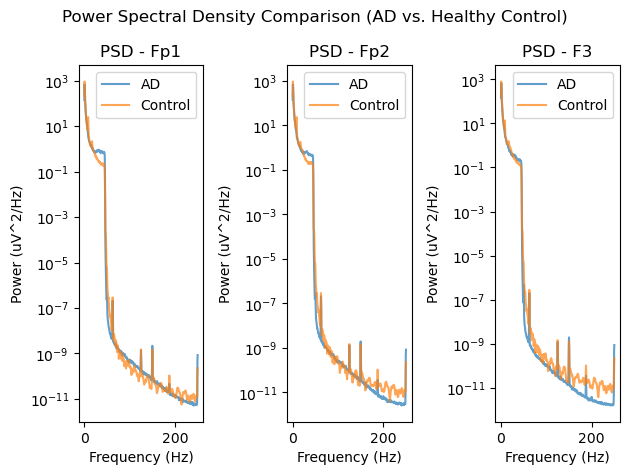

In [8]:
bands = { "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 100), }

for i, channel in enumerate(["Fp1", "Fp2", "F3"]):
    # Compute PSD using Welch's method
    f_ad, psd_ad = welch(processed_AD[i], fs, nperseg=fs*2)
    f_control, psd_control = welch(processed_Control[i], fs, nperseg=fs*2)

    # Plot
    plt.subplot(1, 3, i + 1)
    plt.semilogy(f_ad, psd_ad, label="AD", alpha=0.7)
    plt.semilogy(f_control, psd_control, label="Control", alpha=0.7)
    plt.title(f"PSD - {channel}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (uV^2/Hz)")
    plt.legend()

plt.suptitle("Power Spectral Density Comparison (AD vs. Healthy Control)")
plt.tight_layout()
plt.show()

In [16]:
# Function to compute relative power in different EEG bands
def compute_band_power(psd, freqs, bands):
    band_power = {}
    total_power = np.trapz(psd, freqs)  # Total power across all frequencies

    for band, (low, high) in bands.items():
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        band_power[band] = np.trapz(psd[idx_band], freqs[idx_band]) / total_power  # Relative power

    return band_power

# Compute relative power for each channel and group
band_powers_ad = {ch: compute_band_power(*welch(processed_AD[i], fs, nperseg=fs*2), bands) for i, ch in enumerate(["Fp1", "Fp2", "F3"])}
band_powers_control = {ch: compute_band_power(*welch(processed_Control[i], fs, nperseg=fs*2), bands) for i, ch in enumerate(["Fp1", "Fp2", "F3"])}

df_ad = pd.DataFrame(band_powers_ad).T
df_control = pd.DataFrame(band_powers_control).T

# Add group labels
df_ad["Group"] = "AD"
df_control["Group"] = "Control"

# Combine both dataframes
df_power_comparison = pd.concat([df_ad, df_control])
df_power_comparison

,Delta,Theta,Alpha,Beta,Gamma,Group
Fp1,0.050995,0.023619,0.014280,0.058762,0.178609,AD
Fp2,0.045830,0.025275,0.010527,0.055365,0.178133,AD
F3,0.042863,0.022785,0.009068,0.069639,0.148673,AD
Fp1,0.035300,0.016522,0.000383,-0.026437,0.102970,Control
Fp2,0.032409,0.021949,0.002759,-0.022375,0.097684,Control
F3,0.038504,0.003239,-0.011220,0.032809,0.098994,Control


In [22]:

# Perform independent t-tests for each frequency band
t_test_results = {}
for band in bands.keys():
    ad_values = df_ad[band].values
    control_values = df_control[band].values
    t_stat, p_value = ttest_ind(ad_values, control_values, equal_var=False)
    t_test_results[band] = {"T-statistic": t_stat, "P-value": p_value}

# Convert results to a dataframe
df_t_tests = pd.DataFrame(t_test_results).T
df_t_t